In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline


In [2]:
# 1. reading in data
path = 'D:\\Python\\DataScience\\DataScience6105\\Assignment2'


In [4]:
df_raw = pd.read_csv(f'{path}/houseprice_train.csv')
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# 2. Define functions for this machine learning exerise
'''Define functions to preprocess data - split dates, categorize, impute'''
def split_dates(df,date_column):
    date_df = pd.DataFrame({"year": df[date_column].dt.year,
              "month": df[date_column].dt.month,
              "day": df[date_column].dt.day,
              "dayofyear": df[date_column].dt.dayofyear,
              "week": df[date_column].dt.week,
              "weekofyear": df[date_column].dt.weekofyear,
              "dayofweek": df[date_column].dt.dayofweek,
              "weekday": df[date_column].dt.weekday,
              "quarter": df[date_column].dt.quarter,
             })
    df = df.drop(date_column,axis = 1)
    df = pd.concat([df,date_df],axis = 1)
    return df

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df
def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res


In [7]:
# 3. Preprocess train data using the defined functions
df_raw_2 = str_to_cat(df_raw)
df_raw_3,my_table = mydf_preprocessor(df_raw_2,null_table = None)
df_raw_3.head(3)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,1,60,4,65.0,8450,2,0,4,4,1,...,0,0,2,2008,9,5,208500,False,False,False
1,2,20,4,80.0,9600,2,0,4,4,1,...,0,0,5,2007,9,5,181500,False,False,False
2,3,60,4,68.0,11250,2,0,1,4,1,...,0,0,9,2008,9,5,223500,False,False,False


In [8]:
'''Define functions to split data, measure accuracy, and r-squared'''
def split_df(df,num):
    return df[ :num].copy(),df[num: ].copy()

def my_rmse(y1,y2):
    return np.sqrt(((y1-y2)**2).mean())

def rsq_n_rmse(my_model,x_train,y_train,x_val,y_val):
    result = [my_model.score(x_train,y_train),my_model.score(x_val,y_val),
             my_rmse(my_model.predict(x_train),y_train),my_rmse(my_model.predict(x_val),y_val)]
    return "train rsq,val rsq,train rmse, val rmse", result


In [9]:
df_raw_3.shape


(1460, 84)

In [40]:
# split the valid subset and training subset from the dataset
x = df_raw_3.drop('SalePrice', axis=1)
y = df_raw_3['SalePrice']
x_trn,x_val = split_df(x,975)
y_trn,y_val = split_df(y,975)


In [42]:
# 4. Model building, hyperparameter tuning, and some exploratory data analysis (EDA)
mod_1 = RandomForestRegressor(n_jobs = -1,oob_score = False,n_estimators = 50,
                                   max_depth = 40000,min_samples_leaf = 25)
mod_1.fit(x_trn,y_trn)
rsq_n_rmse(mod_1,x_trn,y_trn,x_val,y_val)


('train rsq,val rsq,train rmse, val rmse',
 [0.8422909184284905,
  0.7710997865895359,
  31847.906617733188,
  37207.122749407565])

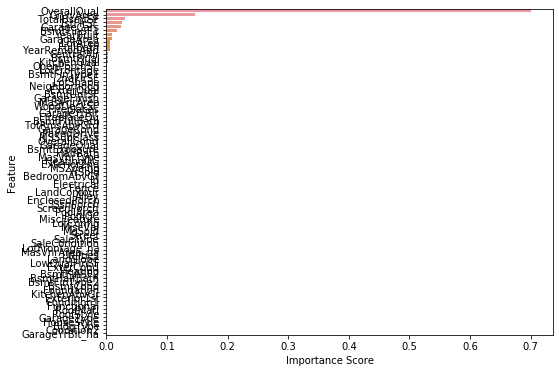

In [13]:
feat_imps = pd.DataFrame(mod_1.feature_importances_, index = x_trn.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")


In [14]:
df_raw_3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 84 columns):
Id                1460 non-null int64
MSSubClass        1460 non-null int64
MSZoning          1460 non-null int8
LotFrontage       1460 non-null float64
LotArea           1460 non-null int64
Street            1460 non-null int8
Alley             1460 non-null int8
LotShape          1460 non-null int8
LandContour       1460 non-null int8
Utilities         1460 non-null int8
LotConfig         1460 non-null int8
LandSlope         1460 non-null int8
Neighborhood      1460 non-null int8
Condition1        1460 non-null int8
Condition2        1460 non-null int8
BldgType          1460 non-null int8
HouseStyle        1460 non-null int8
OverallQual       1460 non-null int64
OverallCond       1460 non-null int64
YearBuilt         1460 non-null int64
YearRemodAdd      1460 non-null int64
RoofStyle         1460 non-null int8
RoofMatl          1460 non-null int8
Exterior1st       1460 non-null 

In [39]:
# After analyzing the feature importance, I begin drop the columns and try. 
x_1 = x.drop(["GarageYrBlt_na","SaleCondition","BedroomAbvGr","LandSlope","Neighborhood","MiscFeature"], axis=1)
x_trn_1,x_val_1 = split_df(x_1,975)
mod_2 = RandomForestRegressor(n_jobs = -1,oob_score = False,n_estimators = 50,
                                   max_depth = 40000,min_samples_leaf = 25)
mod_2.fit(x_trn_1,y_trn)
rsq_n_rmse(mod_2,x_trn_1,y_trn,x_val_1,y_val)


('train rsq,val rsq,train rmse, val rmse',
 [0.838324112481135, 0.7646858136282639, 32245.94929230709, 37724.80845764697])

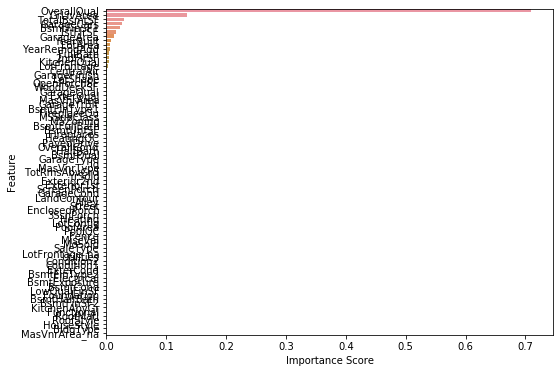

In [18]:
feat_imps = pd.DataFrame(mod_2.feature_importances_, index = x_trn_1.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")


In [36]:
x_2 = x_1.drop(["MasVnrArea_na","HouseStyle","LotFrontage","LowQualFinSF","EnclosedPorch","GarageType","OverallCond","Fence"],axis=1)
x_trn_2,x_val_2 = split_df(x_2,975)
mod_3 = RandomForestRegressor(n_jobs = -1,oob_score = False,n_estimators = 50,
                                   max_depth = 40000,min_samples_leaf = 25)
mod_3.fit(x_trn_2,y_trn)
rsq_n_rmse(mod_3,x_trn_2,y_trn,x_val_2,y_val)


('train rsq,val rsq,train rmse, val rmse',
 [0.8353884462450231, 0.7669952165158544, 32537.38880728044, 37539.2340255585])

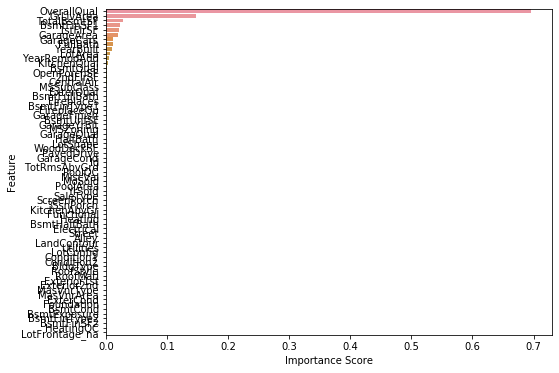

In [21]:
feat_imps = pd.DataFrame(mod_2.feature_importances_, index = x_trn_2.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")


In [37]:
x_3 = x_2.drop(["LotFrontage_na","HeatingQC","LandContour","LotShape","Alley","Exterior1st","PoolArea","RoofMatl","TotRmsAbvGrd","WoodDeckSF","SaleType","ScreenPorch"],axis=1)
x_trn_3,x_val_3 = split_df(x_3,975)
mod_4 = RandomForestRegressor(n_jobs = -1,oob_score = False,n_estimators = 50,
                                   max_depth = 40000,min_samples_leaf = 25)
mod_4.fit(x_trn_3,y_trn)
rsq_n_rmse(mod_4,x_trn_3,y_trn,x_val_3,y_val)


('train rsq,val rsq,train rmse, val rmse',
 [0.8326401422518335,
  0.7552219586888361,
  32807.881594615326,
  38475.93796975751])

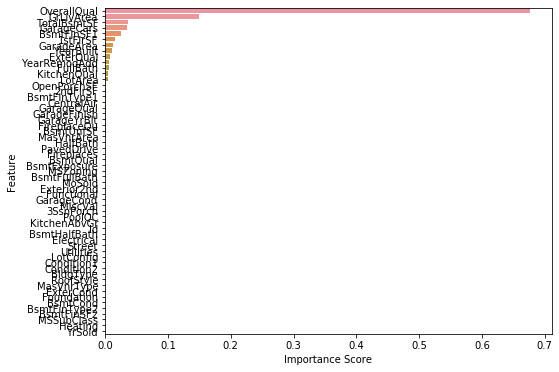

In [23]:
feat_imps = pd.DataFrame(mod_2.feature_importances_, index = x_trn_3.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")


In [24]:
x_4 = x_3.drop(["YrSold","Heating","MSSubClass","BsmtFinSF2","BsmtFinType2","BsmtCond","ExterCond","MasVnrType","RoofStyle","Condition1","Condition2","LotConfig","Street","Electrical","BsmtHalfBath","KitchenAbvGr","PoolQC","3SsnPorch","GarageCond","Exterior2nd","MoSold","BsmtFullBath"],axis=1)
x_trn_4,x_val_4 = split_df(x_4,975)
mod_2.fit(x_trn_4,y_trn)
rsq_n_rmse(mod_2,x_trn_4,y_trn,x_val_4,y_val)


('train rsq,val rsq,train rmse, val rmse',
 [0.8401626491916834,
  0.7664699388419836,
  32062.078734610026,
  37581.523760042044])

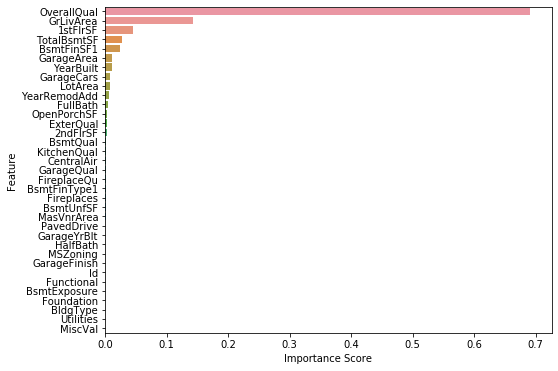

In [25]:
feat_imps = pd.DataFrame(mod_2.feature_importances_, index = x_trn_4.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")


In [29]:
x_5 = x_4.drop(["MiscVal","Utilities","BldgType","Foundation","BsmtExposure","Functional","Id","GarageFinish","MSZoning","HalfBath","GarageYrBlt","PavedDrive","MasVnrArea","BsmtUnfSF","Fireplaces","BsmtFinType1","FireplaceQu","GarageQual","CentralAir","KitchenQual","BsmtQual"],axis=1)
x_trn_5,x_val_5 = split_df(x_5,975)
mod_2.fit(x_trn_5,y_trn)
rsq_n_rmse(mod_2,x_trn_5,y_trn,x_val_5,y_val)


('train rsq,val rsq,train rmse, val rmse',
 [0.8369586776371445,
  0.767699399398987,
  32381.829696434164,
  37482.46590186159])

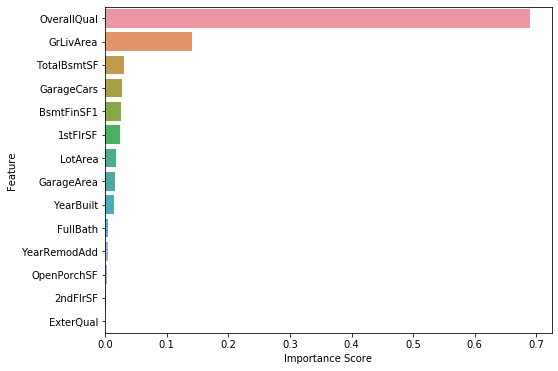

In [30]:
feat_imps = pd.DataFrame(mod_2.feature_importances_, index = x_trn_5.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")


In [32]:
x_6 = x_5.drop(["ExterQual","2ndFlrSF","OpenPorchSF","YearRemodAdd","FullBath"],axis=1)
x_trn_6,x_val_6 = split_df(x_6,975)
mod_2.fit(x_trn_6,y_trn)
rsq_n_rmse(mod_2,x_trn_6,y_trn,x_val_6,y_val)


('train rsq,val rsq,train rmse, val rmse',
 [0.8326142996590199,
  0.7603424426475635,
  32810.414483952045,
  38071.37415014129])

In [33]:
'''Read in test data'''
test_raw = pd.read_csv(f'{path}/houseprice_test.csv')
test_raw_2 = str_to_cat(test_raw)
test_raw_3,my_table_1 = mydf_preprocessor(test_raw_2,null_table = my_table)
test_raw_3.head(3)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MasVnrArea_na,BsmtFinSF1_na,BsmtFinSF2_na,BsmtUnfSF_na,TotalBsmtSF_na,BsmtFullBath_na,BsmtHalfBath_na,GarageYrBlt_na,GarageCars_na,GarageArea_na
0,1461,20,3,80.0,11622,2,0,4,4,1,...,False,False,False,False,False,False,False,False,False,False
1,1462,20,4,81.0,14267,2,0,1,4,1,...,False,False,False,False,False,False,False,False,False,False
2,1463,60,4,74.0,13830,2,0,1,4,1,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
test_raw_4,my_table_2 = mydf_preprocessor(test_raw_2,null_table=my_table)


In [47]:
test_raw_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 91 columns):
Id                 1459 non-null int64
MSSubClass         1459 non-null int64
MSZoning           1459 non-null int8
LotFrontage        1459 non-null float64
LotArea            1459 non-null int64
Street             1459 non-null int8
Alley              1459 non-null int8
LotShape           1459 non-null int8
LandContour        1459 non-null int8
Utilities          1459 non-null int8
LotConfig          1459 non-null int8
LandSlope          1459 non-null int8
Neighborhood       1459 non-null int8
Condition1         1459 non-null int8
Condition2         1459 non-null int8
BldgType           1459 non-null int8
HouseStyle         1459 non-null int8
OverallQual        1459 non-null int64
OverallCond        1459 non-null int64
YearBuilt          1459 non-null int64
YearRemodAdd       1459 non-null int64
RoofStyle          1459 non-null int8
RoofMatl           1459 non-null int8
Exterior1

In [48]:
df_raw_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 84 columns):
Id                1460 non-null int64
MSSubClass        1460 non-null int64
MSZoning          1460 non-null int8
LotFrontage       1460 non-null float64
LotArea           1460 non-null int64
Street            1460 non-null int8
Alley             1460 non-null int8
LotShape          1460 non-null int8
LandContour       1460 non-null int8
Utilities         1460 non-null int8
LotConfig         1460 non-null int8
LandSlope         1460 non-null int8
Neighborhood      1460 non-null int8
Condition1        1460 non-null int8
Condition2        1460 non-null int8
BldgType          1460 non-null int8
HouseStyle        1460 non-null int8
OverallQual       1460 non-null int64
OverallCond       1460 non-null int64
YearBuilt         1460 non-null int64
YearRemodAdd      1460 non-null int64
RoofStyle         1460 non-null int8
RoofMatl          1460 non-null int8
Exterior1st       1460 non-null 

In [ ]:
y_test_pred = mod_1.predict(test_raw_3)
print(y_test_pred)